In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce

# Load the datasets
train_data = pd.read_csv('aug_train.csv')
test_data = pd.read_csv('aug_test.csv')

# Display the first few rows of the training dataset
print(train_data.head())

# Handle missing values
imputer = SimpleImputer(strategy='median')
train_data_imputed = imputer.fit_transform(train_data.select_dtypes(include=[np.number]))
train_data[train_data.select_dtypes(include=[np.number]).columns] = train_data_imputed

# Encode categorical features
encoder = ce.TargetEncoder()
train_data_encoded = encoder.fit_transform(train_data.select_dtypes(include=[object]), train_data['target'])
train_data[train_data.select_dtypes(include=[object]).columns] = train_data_encoded

# Normalize numerical features, excluding the target variable
numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('target')
scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

# Ensure the target is binary (0 or 1)
train_data['target'] = train_data['target'].apply(lambda x: 1 if x >= 0.5 else 0)

# Split the data into features and target
X = train_data.drop('target', axis=1)
y = train_data['target']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM     

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train an XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate the model
print(f'XGBoost Accuracy: {accuracy_score(y_val, y_pred_xgb)}')
print(classification_report(y_val, y_pred_xgb))


XGBoost Accuracy: 0.7839248434237995
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2880
           1       0.57      0.50      0.54       952

    accuracy                           0.78      3832
   macro avg       0.71      0.69      0.70      3832
weighted avg       0.78      0.78      0.78      3832



In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert target to categorical
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

# Build a neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
y_pred_nn = model.predict(X_val)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Evaluate the model
print(f'Neural Network Accuracy: {accuracy_score(y_val, y_pred_nn_classes)}')
print(classification_report(y_val, y_pred_nn_classes))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7408 - loss: 0.5314 - val_accuracy: 0.7965 - val_loss: 0.4485
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7848 - loss: 0.4650 - val_accuracy: 0.7906 - val_loss: 0.4494
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7776 - loss: 0.4612 - val_accuracy: 0.7968 - val_loss: 0.4476
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7782 - loss: 0.4575 - val_accuracy: 0.7932 - val_loss: 0.4429
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7947 - loss: 0.4435 - val_accuracy: 0.7939 - val_loss: 0.4428
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7830 - loss: 0.4515 - val_accuracy: 0.8020 - val_loss: 0.4399
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7900 - loss: 0.4400 - val_accuracy: 0.8010 - val_loss: 0.4458
Epoch 8/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7945 - loss: 0.4488 - val_accuracy: 0.

In [7]:
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Define sensitive features
sensitive_features = X_val[['gender', 'enrollee_id']]

# Evaluate fairness for XGBoost model
metric_frame_xgb = MetricFrame(metrics={'accuracy': accuracy_score,
                                        'selection_rate': selection_rate},
                               y_true=y_val,
                               y_pred=y_pred_xgb,
                               sensitive_features=sensitive_features)

dp_diff_xgb = demographic_parity_difference(y_val, y_pred_xgb, sensitive_features=sensitive_features)
eo_diff_xgb = equalized_odds_difference(y_val, y_pred_xgb, sensitive_features=sensitive_features)

print(metric_frame_xgb.by_group)
print(f'Demographic Parity Difference (XGBoost): {dp_diff_xgb}')
print(f'Equalized Odds Difference (XGBoost): {eo_diff_xgb}')


                       accuracy  selection_rate
gender    enrollee_id                          
-0.635723 -1.754397         1.0             0.0
          -1.753877         NaN             NaN
          -1.753773         1.0             0.0
          -1.751486         1.0             0.0
          -1.751174         1.0             0.0
...                         ...             ...
 1.735510  1.708670         NaN             NaN
           1.710958         NaN             NaN
           1.713038         NaN             NaN
           1.713246         NaN             NaN
           1.715118         1.0             0.0

[15328 rows x 2 columns]
Demographic Parity Difference (XGBoost): 1.0
Equalized Odds Difference (XGBoost): 1.0


In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


# Define the mitigation technique
mitigator = ExponentiatedGradient(estimator=XGBClassifier(),
                                  constraints=DemographicParity())

# Apply the mitigation
mitigator.fit(X_train, y_train, sensitive_features=X_train[['gender', 'enrollee_id']])

# Make predictions with the mitigated model
y_pred_mitigated = mitigator.predict(X_val)

# Evaluate the mitigated model
print(f'Mitigated Accuracy: {accuracy_score(y_val, y_pred_mitigated)}')
print(classification_report(y_val, y_pred_mitigated))

# Re-evaluate fairness
metric_frame_mitigated = MetricFrame(metrics={'accuracy': accuracy_score,
                                              'selection_rate': selection_rate},
                                     y_true=y_val,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=X_val[['gender', 'enrollee_id']])

mitigated_dp_diff = demographic_parity_difference(y_val, y_pred_mitigated, sensitive_features=X_val[['gender', 'enrollee_id']])
mitigated_eo_diff = equalized_odds_difference(y_val, y_pred_mitigated, sensitive_features=X_val[['gender', 'enrollee_id']])

print(metric_frame_mitigated.by_group)
print(f'Mitigated Demographic Parity Difference: {mitigated_dp_diff}')
print(f'Mitigated Equalized Odds Difference: {mitigated_eo_diff}')


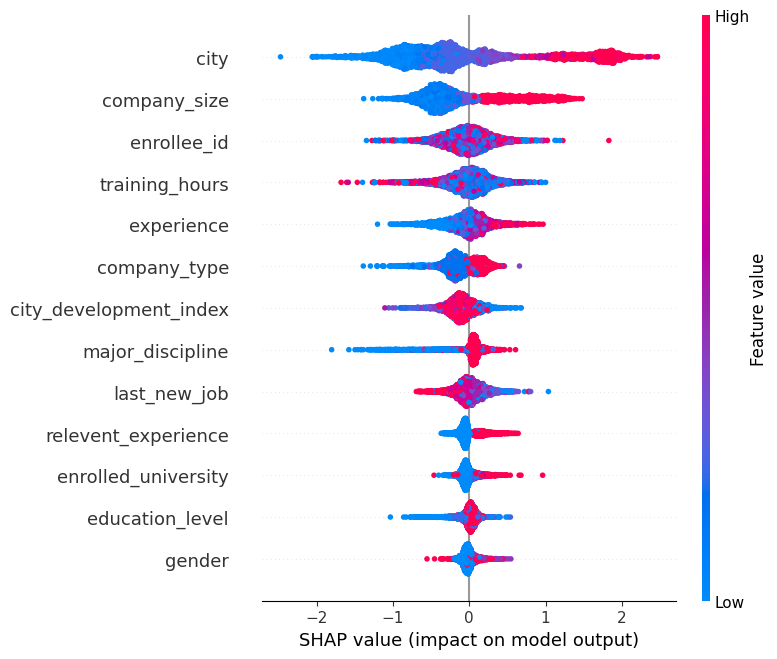

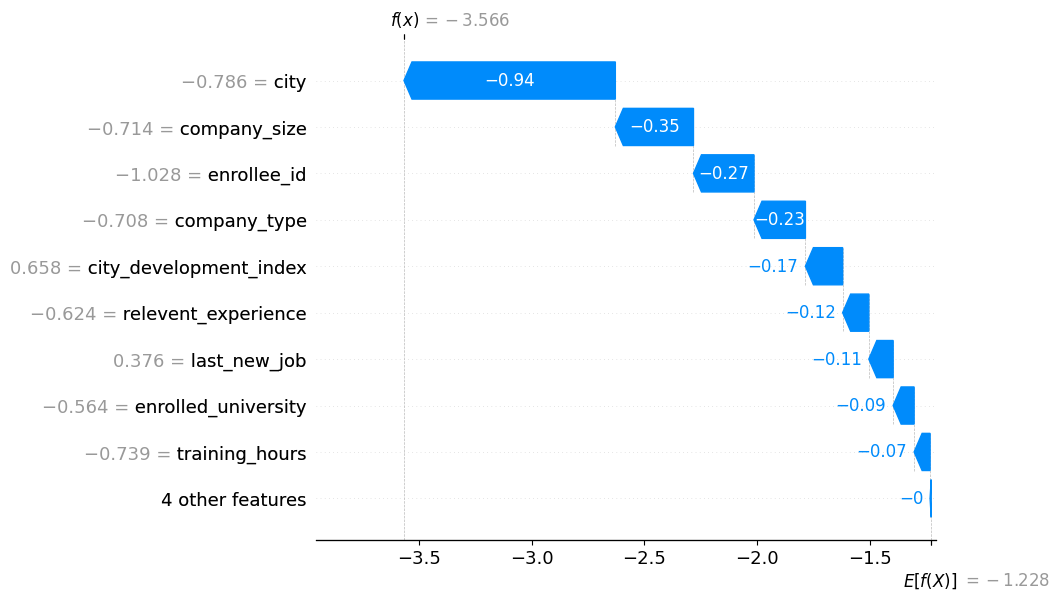

In [11]:
import shap

# Explain the XGBoost model predictions
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_val)

# Plot the SHAP values
shap.summary_plot(shap_values, X_val)

# Local explanations for an individual prediction
shap.plots.waterfall(shap_values[0])


In [10]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.7 MB/s eta 0:00:00


In [12]:
from sklearn.utils import resample

# Check for model stability with bootstrap sampling
bootstrap_accuracies = []
n_iterations = 100
for i in range(n_iterations):
    X_sample, y_sample = resample(X_val, y_val, random_state=i)
    y_pred_sample = xgb_model.predict(X_sample)
    bootstrap_accuracies.append(accuracy_score(y_sample, y_pred_sample))

print(f'Bootstrap Accuracy Mean: {np.mean(bootstrap_accuracies)}')
print(f'Bootstrap Accuracy Std: {np.std(bootstrap_accuracies)}')


Bootstrap Accuracy Mean: 0.7841675365344467
Bootstrap Accuracy Std: 0.006841766345507735
